In [39]:
import tensorflow.keras.backend as K
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

from glob import glob
from copy import deepcopy
from collections import defaultdict
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications import resnet50

In [46]:
from fl_tissue_model_tools import data_prep, dev_config, models, defs
import fl_tissue_model_tools.preprocessing as prep

In [3]:
dirs = dev_config.get_dev_directories("../dev_paths.txt")

In [4]:
root_data_path = f"{dirs.data_dir}/invasion_data/development"
resnet_inp_shape = (128, 128, 3)
# Binary classification -> only need 1 output unit
n_outputs = 1
val_split = 0.3
batch_size = 32
# n_epochs = 10
frozen_epochs = 10
fine_tune_epochs = 10
fine_tune_lr = 1e-5
seed = 123
class_labels = {"no_invasion": 0, "invasion": 1}
rs = np.random.RandomState(seed)

In [6]:
def balanced_class_weights_from_counts(d):
    n = np.sum(list(d.values()))
    n_c = len(d.keys())
    weights = {}
    for ci, n_ci in d.items():
        weights[ci] = n / (n_c * n_ci)
    return weights

# Class proportions

In [7]:
img_paths = {k: glob(f"{root_data_path}/train/{k}/*.tif") for k in class_labels.keys()}
img_counts = {c: len(pn) for c, pn in img_paths.items()}

In [8]:
class_weights = balanced_class_weights_from_counts(img_counts)

In [9]:
class_weights

{'no_invasion': 0.5426997245179064, 'invasion': 6.354838709677419}

# Datasets

In [74]:
class InvasionDataGenerator(Sequence):
    def __init__(self, datapath, batch_size, img_shape, class_labels, random_state, file_ext="tif", shuffle=True, balanced=True):
        self.datapath = datapath
        self.batch_size = batch_size
        self.img_shape = img_shape
        self.class_labels = deepcopy(class_labels)
        self.file_ext = file_ext
        self.class_paths = {}
        self.class_counts = {}
        self.img_paths = []
        self.img_labels = []
        self.shuffle = shuffle
        self.rs = random_state
        self._get_paths_and_counts()
        self.indices = np.arange(len(self.img_paths), dtype=np.uint)
        if balanced == True:
            self.class_weights = balanced_class_weights_from_counts(self.class_counts)
        else:
            self.class_weights = None

    def __len__(self):
        # return len()
        return len(self.img_paths) // self.batch_size

    def __getitem__(self, index):
        # batch_y = train_labels[idx:idx+batch_size]
        # batch_x = self.load_and_preprocess_function()
        # return (batch_x, batch_y)
        # pass
        # Generate indexes of the batch
        # indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        batch_idx_start = index * self.batch_size
        batch_idx_end = batch_idx_start + batch_size
        batch_indices = self.indices[batch_idx_start: batch_idx_end]

        img_paths = [self.img_paths[i] for i in batch_indices]
        # Should it be (B,) or (B,1)?
        y = np.array([self.img_labels[i] for i in batch_indices])

        # Generate data
        X = np.array([self.prep_image(ip) for ip in img_paths])

        return X, y

    
    def _get_paths_and_counts(self):
        self.class_paths = {v: glob(f"{self.datapath}/{k}/*.{self.file_ext}") for k, v in self.class_labels.items()}
        self.class_counts = {c: len(pn) for c, pn in self.class_paths.items()}
        for k, v in self.class_paths.items():
            # Paths to each image
            self.img_paths.extend(v)
            # Associate labels with each image path
            self.img_labels.extend(list(np.repeat(k, len(v))))
    
    def on_epoch_end(self):
        # self.indices = np.arange(len(self.list_IDs))
        # if self.shuffle == True:
        #     print("Shuffling...")
        #     np.random.shuffle(self.indexes)
        self.indices = np.arange(len(self.img_paths), dtype=np.uint)
        if self.shuffle == True:
            print("shuffling")
            self.rs.shuffle(self.indices)

    def prep_image(self, path):
        img = cv2.imread(path, cv2.IMREAD_ANYDEPTH)
        # img = load_img(path, target_size=self.img_shape, color_mode="grayscale", interpolation="lanczos")
        img = prep.min_max_(cv2.resize(img, self.img_shape, cv2.INTER_LANCZOS4).astype(np.float32), 0, 1, defs.TIF_MIN, defs.TIF_MAX)
        # return np.stack([img, img, img], axis=-1)
        return np.repeat(img[:, :, np.newaxis], 3, axis=2)
        # return img

In [75]:
train_datagen = InvasionDataGenerator(f"{root_data_path}/train", 32, resnet_inp_shape[:2], class_labels, rs)

In [76]:
Xi, yi = train_datagen[1]

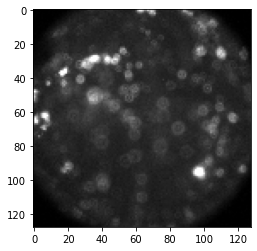

In [77]:
plt.imshow(Xi[0], cmap="gray")

In [ ]:
# train_datagen = ImageDataGenerator(
#     horizontal_flip=True,
#     vertical_flip=True,
#     rotation_range=360,
#     # Make sure to preprocess the same as the original model
#     preprocessing_function=resnet50.preprocess_input,
#     # preprocessing_function=rgb2gray2rbg_then_resnet50,
#     validation_split=val_split
# )
# train_generator = train_datagen.flow_from_directory(
#     f"{root_data_path}/train",
#     target_size=resnet_inp_shape[:2],
#     batch_size=batch_size,
#     # Want uninfected to be labeled "0"
#     classes=class_labels,
#     class_mode="binary",
#     seed=seed,
#     subset="training"
# )

# val_generator = train_datagen.flow_from_directory(
#     f"{root_data_path}/train",
#     target_size=resnet_inp_shape[:2],
#     batch_size=batch_size,
#     classes=class_labels,
#     class_mode="binary",
#     seed=seed,
#     subset="validation"
# )

# Model

In [ ]:
tl_model = models.build_ResNet50_TL(
    n_outputs,
    resnet_inp_shape,
    # base_last_layer="conv5_block3_out",
    # base_last_layer="conv5_block2_out",
    # base_last_layer="conv5_block1_out",
    base_last_layer="conv4_block6_out",
    # base_last_layer="conv3_block4_out",
    # Switch to softmax once n_outputs > 1
    output_act="sigmoid",
    base_model_trainable=False
)
tl_model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=[BinaryAccuracy()])

In [ ]:
K.clear_session()